In [14]:
import getpass
import os
import pprint
from dotenv import load_dotenv

load_dotenv()

# os.environ["OPENAI_API_KEY"] = getpass.getpass()

tracing_v2 = os.getenv("LANGCHAIN_TRACING_V2")
langchain_api_key = os.getenv("LANGCHAIN_API_KEY")
openai_api_key = os.getenv("OPENAI_API_KEY")

from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-3.5-turbo")

## Invoking model and parsing the response.
The model response contains the response string along with other metadata bout the response. StrOutputPraser is used to parse the model response.

In [9]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser

messages = [
    SystemMessage(content="Translate the following from English into Italian"),
    HumanMessage(content="hi!"),
]

result = model.invoke(messages)

# Used to parse the model response.
parser = StrOutputParser()
parser.invoke(result)



'Ciao!'

## Chaining the model with an output parser
A quicker way to do this is to "chain the model with the output parser. this means the ouptut parser will get called everytime in this chain. You can create a chain using the `|` operator. This is used in LangChain to combine two elements together.

In [10]:
chain = model | parser
chain.invoke(messages)

'Ciao!'

In Langsmith, you can now see the entire chain. It has two steps.
1. Language model is called
2. Result is passed to the output parser

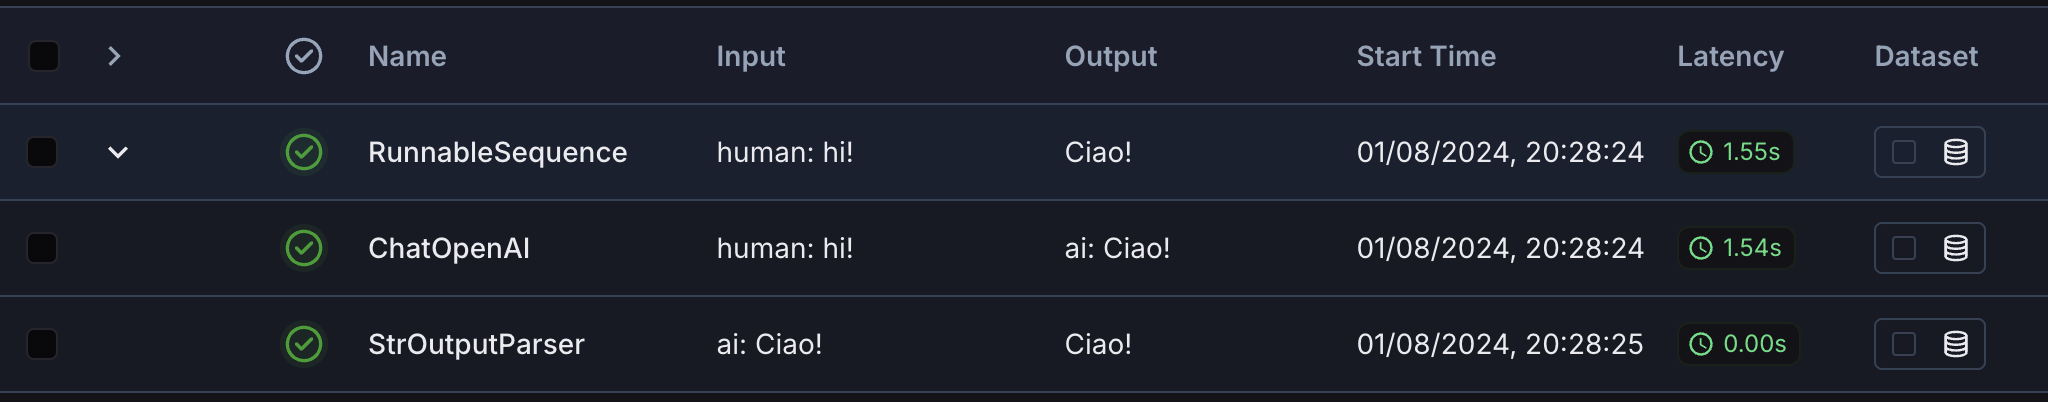

# Prompt Templates
Prompt templates are used to construct the message array that is passed to the model. usually this is constructed from a combination of user input and application logic.

PromptTemplate takes in two user variables:
- `language`: the Language to transalte text into
- `text`: The text to translate

In [18]:
from langchain_core.prompts import ChatPromptTemplate

system_template = "Translate the following into {language}:"

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "{text}")]
)

result = prompt_template.invoke({"language": "italian", "text": "hi"})

# result
result.to_messages()

[SystemMessage(content='Translate the following into italian:'),
 HumanMessage(content='hi')]

You can now chain this with the model and output parser using the `|` operator.

THOUGHT: You can chain components that you can call invoke on.

In [20]:
chain = prompt_template | model | parser
chain.invoke({"language": "mandarin", "text": "hi"})

'你好'

# Serving with Langserve
This is now ready to be deployed as an application - an API application. This is where LangServe comes in. It helps us deploy LangChain chains as a REST API.

Install with:
```bash
pip install "langserve[all]
```

## Server
To create the server, make a `serve.py` file. This will contain three things:
1. The definition of our chain that we just built above
2. Our FastAPI app
3. A definition of a route from which to serve the chain, which is done with `langserve.add_routes`.

See `01_simple-llm-app-with-LCEL/serve.py`. 

Execute the file with:
```bash
python serve.py
```
you should see the chain being served at http://localhost:8000.

## Playground
Every LangServe services come with a simple built-in UI to configure and invoke the application with streaming output and visibility into the intermediate steps. Head to http://localhost:8000/chain/playground/.

## Simulating Client interaction
Now that the API is deployed, you can simulate programmatically interacting with the service from a client with `langserve.RemoteRunnable`. 

In [21]:
from langserve import RemoteRunnable

remote_chain = RemoteRunnable("http://localhost:8000/chain/")
remote_chain.invoke({"language": "italian", "text": "hi"})

'Ciao'